# Asset returns

Let $P_t$ be the price of an asset at time $t$. We'll define the *gross return* on the asset over one period as

$$1+R_t = \frac{P_t + D_t}{P_{t-1}},$$

where $D_t$ denotes the value of any dividends paid during the period.

The *net return* is simply

$$R_t = \frac{P_t + D_t}{P_{t-1}} - 1 = \frac{P_t - P_{t-1}}{P_{t-1}} + \frac{D_t}{P_{t-1}}.$$

The first term is the *capital gains yield* and the second is the *dividend yield*.

In [3]:
import numpy as np
import pandas as pd

In [10]:
pd.options.display.max_rows = None

As an example, we'll work with some historical price data for Apple, which we'll get from Yahoo! finance using [pandas-datareader](https://pydata.github.io/pandas-datareader/).

In [2]:
import pandas_datareader as pdr

# require version 10 or higher
assert int(pdr.__version__.split('.')[1]) >= 10

In [93]:
prcs = pdr.get_data_yahoo('AAPL', 2019, 2021, get_actions=True)

The data include the intraday high, low price, along with the opening and closing price as well as volume of shares traded. We can also see when a dividend was paid or a stock split occurred.

In [95]:
(prcs.loc['2020-08':'2020-09']
    .style.format_index(lambda s: s.strftime("%Y-%m-%d"))
    .format(precision=2, na_rep='–')
    .format(formatter='{:,.0f}', subset=['Volume'])
    .applymap(lambda x: 'background-color: lightgreen' if x>0 else '', subset=['Dividends', 'Splits'])
)

,High,Low,Open,Close,Volume,Adj Close,Dividends,Splits
Date,,,,,,,,
2020-08-03,111.64,107.89,108.20,108.94,"308,151,200",107.44,–,–
2020-08-04,110.79,108.39,109.13,109.67,"173,071,600",108.16,–,–
2020-08-05,110.39,108.90,109.38,110.06,"121,776,800",108.55,–,–
2020-08-06,114.41,109.80,110.40,113.90,"202,428,800",112.34,–,–
2020-08-07,113.68,110.29,113.21,111.11,"198,045,600",109.79,0.20,–
2020-08-10,113.78,110.00,112.60,112.73,"212,403,600",111.38,–,–
2020-08-11,112.48,109.11,111.97,109.38,"187,902,400",108.07,–,–
2020-08-12,113.28,110.30,110.50,113.01,"165,598,000",111.66,–,–
2020-08-13,116.04,113.93,114.43,115.01,"210,082,000",113.64,–,–


<span class="tex2jax_ignore">All of the price data are adjusted for stock splits, meaning that they reflect the number of shares outstanding after the split. For example, we can see that Apple had a 4-for-1 split on August 31, 2020. So while the closing price the day before shows &#36;124.81, in reality the closing price that day was &#36;499.23.</span>

:::{Note}

The *adjusted close* [also adjusts](https://help.yahoo.com/kb/SLN28256.html) for dividend payments, but does so in a way that a nonstandard way, so we will not use this series.

:::

We can calculate two return series:

- The capital gains yield, which is simply the percent change in the price series. We'll call this `retx` since this return excludes any dividend payments.
- The total return, which includes dividends. We'll call this `ret`.

The two returns will be the same whenever no dividend is paid.

In [134]:
prcs['retx'] = prcs['Close'].pct_change()

prcs['ret'] = (prcs['Close'] + prcs['Dividends'].fillna(0)) / prcs['Close'].shift() - 1

prcs.loc['2020-08-01':'2020-08-10', ['Dividends', 'retx', 'ret']]

,Dividends,retx,ret
Date,,,
2020-08-03,NaN,0.025198,0.025198
2020-08-04,NaN,0.006678,0.006678
2020-08-05,NaN,0.003625,0.003625
2020-08-06,NaN,0.034889,0.034889
2020-08-07,0.205,-0.024495,-0.022695
2020-08-10,NaN,0.014535,0.014535


Note that

$$\text{ret} - \text{retx} = \frac{D_t}{P_{t-1}},$$

so we can recover the dividend from the difference in these two series by multiplying by the lagged price.

In [133]:
divs = (prcs['ret'] - prcs['retx']) * prcs['Close'].shift()

divs[divs>0]

Date
2019-02-08    0.1825
2019-05-10    0.1925
2019-08-09    0.1925
2019-11-07    0.1925
2020-02-07    0.1925
2020-05-08    0.2050
2020-08-07    0.2050
2020-11-06    0.2050
dtype: float64

In [126]:
import wrds

conn = wrds.Connection()

q = """
        select date, prc, ret, retx, shrout, vol, bidlo, askhi, openprc
        from crsp.dsf 
        where permno = 14593
        and date>='08/01/2020' and date<'09/15/2020'
"""

apple = conn.raw_sql(q, date_cols=['date']).set_index('date')

apple.loc['2020-08-01':'2020-08-10']

## Compound returns

Holding the asset for $k$ periods would earn a gross return of

\begin{align*}
1+R_t[k] = \frac{P_t}{P_{t-k}} &= \frac{P_t}{P_{t-1}} \times \frac{P_{t-1}}{P_{t-2}} \times \cdots \times \frac{P_{t-k+1}}{P_{t-k}} \\
&= (1+R_t)(1+R_{t-1})\cdots(1+R_{t-k+1}) \\
&= \prod_{j=0}^{k-1}(1+R_{t-j}).
\end{align*}

That is, the $k$-period return is simply the product of the $k$ one-period returns; for this reason it is also called the *compound return*.

Assets may generate a return that is compounded over varying intervals. For example, an asset generating a return per year of $R$ but compouning $n$ times per year will have a total return of

$$\left(1+\frac{R}{n}\right)^n.$$

In [20]:
R = 0.1

prds = [1, 2, 4, 12, 52, 365, 24*365]
vals = [(1+R/n)**n for n in prds]
tbl = pd.DataFrame(vals, index=prds, columns=['Gross return'])
tbl.index.name = 'Frequency'

tbl

,Gross return
Frequency,
1,1.100000
2,1.102500
4,1.103813
12,1.104713
52,1.105065
365,1.105156
8760,1.105170


In the limit $n\to\infty$ this leads to a *continuous compounding*,

$$\lim _{n\to \infty }\left(1+{\frac {R}{n}}\right)^{n} = e^R.$$

With continuous compounding, the asset value after one year is

$$e^{0.1} \approx 1.10517.$$

In [21]:
np.exp(0.1)

1.1051709180756477

## Log returns

The *log return*, or *continuously compounded return* is

$$r_t = \ln(1+R_t) = \ln\left(\frac{P_t}{P_{t-1}}\right) = \Delta \ln(P_t),$$

where $\Delta x_t := x_t - x_{t-1}$ is the *difference operator*.

The multiperiod log return is simply the sum of the continuously compounded one-period returns.

\begin{align*}
r_t[k] &= \ln(1+R_t[k]) \\
& = \ln[(1+R_t)(1+R_{t-1}\cdots(1+R_{t-k+1})] \\
&= \ln(1+R_t) + \ln(1+R_{t-1}) + \cdots + \ln(1+R_{t-k+1}) \\
&= r_t + r_{t-1} + \cdots + r_{t-k+1}.
\end{align*}

Recall that the first-order [Taylor expansion](TaylorSeries) of

$$\ln(1+R) \approx R,$$

which implies that, for small returns, the log return will be close to the net return; this similarity breaks down as price changes become larger.

:::{admonition} Exercise

Calculate the log return using the `ret` series. On what dates is the difference between the log return and the standard return greater than 0.005?

:::

In [148]:
prcs['logret'] = np.log(1+prcs['ret'])

mask = (prcs['logret'] - prcs['ret']).abs() > 0.005

prcs[mask]

## Aggregating returns

In [159]:
prcs.resample('M')['logret'].sum()

Date
2019-01-31    0.052546
2019-02-28    0.043798
2019-03-31    0.092603
2019-04-30    0.054901
2019-05-31   -0.132578
2019-06-30    0.122677
2019-07-31    0.073617
2019-08-31   -0.016567
2019-09-30    0.070423
2019-10-31    0.104976
2019-11-30    0.074660
2019-12-31    0.094204
2020-01-31    0.052602
2020-02-29   -0.121798
2020-03-31   -0.072314
2020-04-30    0.144424
2020-05-31    0.081604
2020-06-30    0.137487
2020-07-31    0.152834
2020-08-31    0.196077
2020-09-30   -0.108171
2020-10-31   -0.061888
2020-11-30    0.091207
2020-12-31    0.108472
Freq: M, Name: logret, dtype: float64

In [153]:
prcs.resample('M')['ret'].apply(lambda x: (1+x).product()-1)

Date
2019-01-31    0.053951
2019-02-28    0.044771
2019-03-31    0.097026
2019-04-30    0.056436
2019-05-31   -0.124166
2019-06-30    0.130519
2019-07-31    0.076394
2019-08-31   -0.016430
2019-09-30    0.072962
2019-10-31    0.110684
2019-11-30    0.077517
2019-12-31    0.098784
2020-01-31    0.054010
2020-02-29   -0.114673
2020-03-31   -0.069761
2020-04-30    0.155374
2020-05-31    0.085026
2020-06-30    0.147386
2020-07-31    0.165132
2020-08-31    0.216620
2020-09-30   -0.102526
2020-10-31   -0.060012
2020-11-30    0.095495
2020-12-31    0.114574
Freq: M, Name: ret, dtype: float64

## Constructing a price index

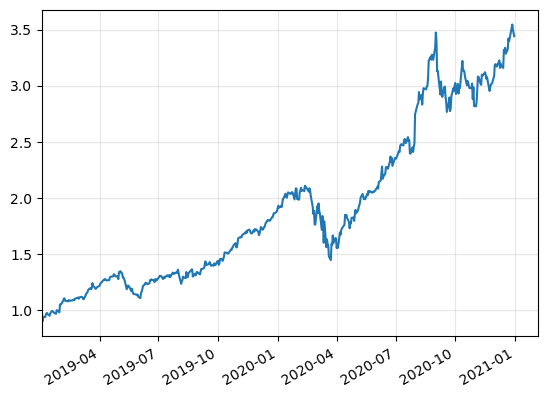

In [272]:
ax = (1+prcs['ret'].fillna(0)).cumprod().plot(xlabel='')
ax.grid(alpha=0.3)
ax.set_xlim(prcs.index[0],None)
plt.show()

## Day and night returns

:::{admonition} Exercise

The [SPDR S&P 500 Trust ETF](https://finance.yahoo.com/quote/SPY?p=SPY), introduced in 1993, is an [exchange-traded fund](https://www.investopedia.com/terms/e/etf.asp) that tracks the performance of the S&P 500 Index.

1. Download the complete history of price data for this ETF.

2. Calculate the return earned while the market is open (Open-to-Close) and the overnight return (Close-to-Open).

3. Confirm that the total day-time and overnight return equals close-to-close return.

4. Calculate the volatility of each return. Interpret your finding.

5. Calculate and plot the cumulative return of the day and night returns. What do you learn from the graph?

6. Calculate the day and night returns for each year. Create a bar chart showing the returns by year.

:::

In [13]:
sp500 = pdr.get_data_yahoo('SPY', 1993)

sp500['ret'] = sp500['Close'].pct_change()
sp500['otc'] = sp500['Close'] / sp500['Open'] - 1
sp500['cto'] = sp500['Open'] / sp500['Close'].shift() - 1

sp500 = sp500.dropna()

np.allclose(
    (1+sp500['otc'])*(1+sp500['cto']) - 1,
    sp500['ret']
)

In [14]:
sp500[['otc', 'cto']].std()

otc    0.009711
cto    0.006737
dtype: float64

In [18]:
import matplotlib.pyplot as plt

from matplotlib.ticker import StrMethodFormatter
from matplotlib.dates import YearLocator, DateFormatter

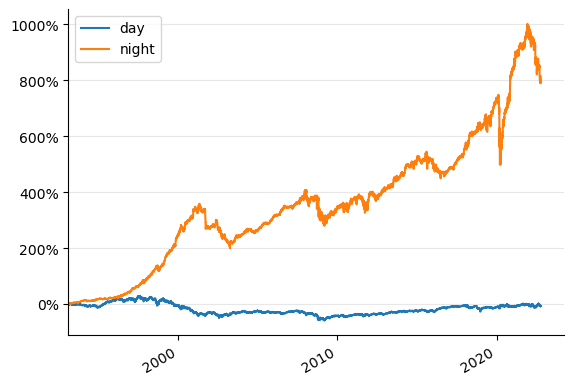

In [15]:
ax = ((1 + sp500[['otc', 'cto']]).cumprod() - 1).plot(xlabel='')

ax.grid(alpha=0.3, axis='y')
for s in ['right', 'top']:
    ax.spines[s].set_visible(False)
ax.set_xlim(sp500.index[0], None)
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.0%}'))
ax.xaxis.set_major_locator(YearLocator(10))
ax.legend(['day', 'night'])
plt.show()

https://www.nytimes.com/2018/02/02/your-money/stock-market-after-hours-trading.html

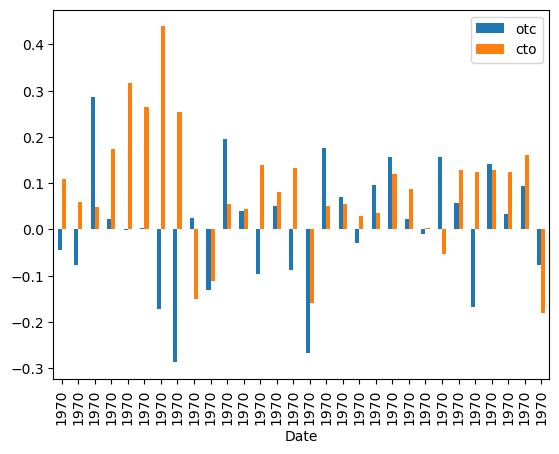

In [19]:
annrets = sp500.resample('A')[['ret', 'otc', 'cto']].apply(lambda x: (1+x).product()) - 1
# annrets.index = annrets.index.year

ax = annrets[['otc', 'cto']].plot.bar()
ax.xaxis.set_major_formatter(DateFormatter('%Y'))